<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import requests
from bs4 import BeautifulSoup
import os
from dotenv import load_dotenv

In [2]:
# Загружаем переменные из .env файла
load_dotenv()

DBNAME = os.getenv('DBNAME')
USER = os.getenv('USER')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

In [4]:
db_params = f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}'
engine = create_engine(db_params)

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies).

In [5]:
query_3_1 = f'''
SELECT
      count(*) cnt_vacancies
FROM
      vacancies
'''

In [6]:
count_vacanties = pd.read_sql_query(query_3_1, engine)
print(f"{count_vacanties['cnt_vacancies'].iloc[0]} вакансий в таблице vacancies")

49197 вакансий в таблице vacancies


2. Напишите запрос, который посчитает количество работодателей (таблица employers).

In [7]:
query_3_2 = f'''
SELECT
      count(*) cnt_employers
FROM
      employers
'''

In [8]:
empl_count = pd.read_sql_query(query_3_2, engine)
print(f"{empl_count['cnt_employers'].iloc[0]} работодатель в таблице employers")

23501 работодатель в таблице employers


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [9]:
query_3_3 = f'''
SELECT
      count(*) cnt_areas
FROM
      areas
'''

In [10]:
areas_count = pd.read_sql_query(query_3_3, engine)
print(f"{areas_count['cnt_areas'].iloc[0]} региона в таблице areas")

1362 региона в таблице areas


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [11]:
query_3_4 = f'''
SELECT
      count(*) cnt_industries
FROM
      industries
'''

In [12]:
industry_count = pd.read_sql_query(query_3_4, engine)
print(f"{industry_count['cnt_industries'].iloc[0]} сферы деятельности в базе (таблица industries)")


294 сферы деятельности в базе (таблица industries)


***

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [13]:
# Подготавливаем SQL-запрос для получения топ-5 городов с максимальным количеством вакансий
query_4_1 = f'''
SELECT
        a.name AS Город,                          -- Имя города
        COUNT(DISTINCT v.name) AS Количество_вакансий  -- Количество уникальных вакансий в данном городе
FROM
        vacancies v                              -- Таблица вакансий
JOIN
        areas a                                  -- Таблица с городами
ON
        a.id = v.area_id                        -- Соединяем по идентификатору города
GROUP BY
        a.name                                   -- Группируем результаты по имени города
ORDER BY
        Количество_вакансий DESC                -- Сортируем результаты по убыванию количества вакансий
LIMIT 5                                        -- Ограничиваем вывод 5 записями
'''

In [14]:
cnt_vacanties_by_area = pd.read_sql_query(query_4_1, engine)
cnt_vacanties_by_area

,Город,Количество_вакансий
0,Москва,3894
1,Санкт-Петербург,2143
2,Новосибирск,1501
3,Минск,1497
4,Алматы,1421


<Figure size 400x700 with 0 Axes>

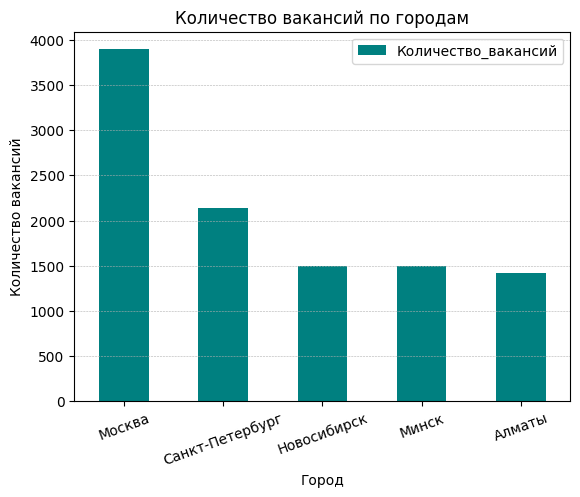

In [15]:
plt.figure(figsize=(4, 7))
cnt_vacanties_by_area.plot(
                            kind='bar',
                            x='Город',
                            y='Количество_вакансий',
                            color='teal'
                            )
plt.xticks(rotation=20)
plt.title('Количество вакансий по городам')
plt.xlabel('Город')
plt.ylabel('Количество вакансий')
plt.grid(
    axis='y',
    linestyle='--',
    linewidth=0.4
    )
plt.show()


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [16]:
query_4_2 = f'''
SELECT
      count(*) cnt_not_null
FROM
      vacancies
WHERE
      salary_from IS NOT NULL
      OR
      salary_to IS NOT NULL
'''

In [17]:
cnt_salary_without_null = pd.read_sql_query(query_4_2, engine)
print(f"У {cnt_salary_without_null['cnt_not_null'].iloc[0]} вакансий заполнено хотя бы одно поле с зарплатой")

У 24073 вакансий заполнено хотя бы одно поле с зарплатой


In [18]:
query_4_2_1 = f'''
SELECT
      ROUND(SUM(CASE WHEN salary_from is null THEN 0 ELSE 1 END)::numeric / COUNT(*) , 2) * 100 from_not_null,
      ROUND(SUM(CASE WHEN salary_to is null THEN 0 ELSE 1 END)::numeric / COUNT(*) , 2) * 100 to_not_null,
      ROUND(SUM(CASE WHEN (salary_from is not null OR salary_to is not null) THEN 1 ELSE 0 END)::numeric / COUNT(*) , 2) * 100 from_or_to_not_null,
      ROUND(SUM(CASE WHEN (salary_from is not null AND salary_to is not null) THEN 1 ELSE 0 END)::numeric / COUNT(*) , 2) * 100 from_and_to_not_null
FROM
      vacancies
'''

In [19]:
r = pd.read_sql_query(query_4_2_1,engine)
r

,from_not_null,to_not_null,from_or_to_not_null,from_and_to_not_null
0,44.0,26.0,49.0,21.0


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [20]:
# Подготавливаем SQL-запрос для получения средней и медианной зарплаты
query_4_3 = f'''
SELECT
      ROUND(AVG(salary_from)) AS avg_salary_from,          -- Средняя зарплата (от) округленная
      ROUND(AVG(salary_to)) AS avg_salary_to,              -- Средняя зарплата (до) округленная
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY salary_from) AS median_salary_from,  -- Медианная зарплата (от)
      PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY salary_to) AS median_salary_to       -- Медианная зарплата (до)
FROM
      vacancies                                             -- Таблица с вакансиями
'''

In [21]:
avg_salary_fork = pd.read_sql_query(query_4_3, engine)
print(f"Среднее значение нижней границы зарплатной вилки равна {avg_salary_fork['avg_salary_from'].iloc[0]}\n\
Среднее значение верхней границы зарплатной вилки равна {avg_salary_fork['avg_salary_to'].iloc[0]}\n\
Медианное значение нижней границы зарплатной вилки равна {avg_salary_fork['median_salary_from'].iloc[0]}\n\
Медианное значение верхней границы зарплатной вилки равна {avg_salary_fork['median_salary_to'].iloc[0]}")

Среднее значение нижней границы зарплатной вилки равна 71065.0
Среднее значение верхней границы зарплатной вилки равна 110537.0
Медианное значение нижней границы зарплатной вилки равна 50000.0
Медианное значение верхней границы зарплатной вилки равна 80000.0


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [22]:
query_4_4 = f'''
SELECT
      schedule,
      employment,
      count(*) as cnt
FROM
      vacancies
GROUP BY
        schedule,
        employment
ORDER BY
        3 DESC
'''

In [23]:
cnt_vacancies_by_shedule_empl = pd.read_sql_query(query_4_4, engine)
cnt_vacancies_by_shedule_empl

,schedule,employment,cnt
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта.

In [24]:
query_4_5 = f'''
SELECT
      experience,
      count(*) as cnt
FROM
      vacancies
GROUP BY
      experience
ORDER BY
        2
'''

In [25]:
cnt_vacancies_by_exp = pd.read_sql_query(query_4_5, engine)
cnt_vacancies_by_exp

,experience,cnt
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


***

* **Лидеры по количеству вакансий**:

Москва, Санкт-Петербург и Новосибирск.
Это объясняется тем, что крупные города обычно имеют развитую экономику и большой рынок труда, что привлекает как местных специалистов, так и талантливых специалистов из других регионов. Также в больших городах чаще встречаются компании различных отраслей, что также способствует большему количеству вакансий.
* **Диапазоны зарплат и карьерный рост**

Только половина вакансий указывает либо нижнюю, либо верхнюю границу зарплаты. В большинстве случаев указывается нижняя граница зарплаты, что говорит о том, что половина вакансий предлагает карьерный рост или возможности для получения более высокой зарплаты. Некоторые вакансии вообще не указывают зарплату, что может означать, что обсуждение зарплаты и условий работы может происходить на этапе собеседования, что может быть как плюсом, так и минусом для соискателей. В целом, наличие различных вариантов зарплаты в вакансиях свидетельствует о разнообразии предложений на рынке труда и дает соискателям возможность выбора.
* **Средние диапазоны зарплат**

Средний диапозон зарплат, которые предлагает работодатель варьируются от 71 тыс.руб до 110 тыс.руб. Но если взглянуть на медианное значение, то получм цифры значительно ниже - от 50 до 80 тыс.руб. Такую разницу получаем за счет крупных городов, потому как в крупных городах уровень зарплат всегда выше.
* **График работы и опыт**

    * Большинство вакансий требуют сотрудников на полную занятость и полный рабочий день. Вакансии на удаленную работу с полным днем в 4,5 раза менее распространены. Среди стажировок и проектных работ также чаще требуются сотрудники на полный день.
    * Работодатели в основном ищут сотрудников с опытом работы от 1 до 6 лет, причем большинство вакансий предназначены для опыта от 1 года до 3 лет. Лишь в 15% вакансий требуются сотрудники без опыта, а в 3% вакансий требуется очень высокий опыт работы, более 6 лет.


# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [26]:
# SQL-запрос для получения топ-5 работодателей по количеству размещенных вакансий
query_5_1 = f'''
SELECT
      e.name AS employer_name,                     -- Имя работодателя
      COUNT(v.id) AS cnt_vacancies                 -- Количество вакансий, размещенных работодателем
FROM
      employers e                                  -- Таблица работодателей
JOIN
      vacancies v                                  -- Таблица вакансий
ON
      v.employer_id = e.id                        -- Соединяем таблицы по идентификатору работодателя
GROUP BY
      e.name                                       -- Группируем результаты по имени работодателя
ORDER BY
      cnt_vacancies DESC                           -- Сортируем по количеству вакансий в порядке убывания
LIMIT
      5                                            -- Ограничиваем вывод 5 записями
'''

In [27]:
# Выполнение SQL-запроса и сохранение результата в DataFrame
cnt_vacancies_by_empl = pd.read_sql_query(query_5_1, engine)

# Вывод информации о работодателе с наибольшим и наименьшим количеством вакансий
print(f"На первом месте по количеству размещенных вакансий находится {cnt_vacancies_by_empl['employer_name'].iloc[0]},\n\
На пятом месте - {cnt_vacancies_by_empl['employer_name'].iloc[4]}")

# Отображение DataFrame с количеством вакансий по работодателям
display(cnt_vacancies_by_empl)

На первом месте по количеству размещенных вакансий находится Яндекс,
На пятом месте - Газпром нефть


,employer_name,cnt_vacancies
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [28]:
# SQL-запрос для получения количества вакансий и работодателей по областям
query_5_2 = f'''
WITH cnt_e AS (  -- Определяем временную таблицу для подсчета работодателей
    SELECT
        a.name AS area_name,                   -- Имя области
        COUNT(DISTINCT e.id) AS cnt_employers  -- Количество уникальных работодателей
    FROM
        areas a                                -- Таблица областей
    LEFT JOIN
        employers e                            -- Таблица работодателей
    ON
        e.area = a.id                         -- Соединяем по идентификатору области
    GROUP BY
        a.name                                -- Группируем результаты по имени области
),
cnt_v AS (  -- Определяем временную таблицу для подсчета вакансий
    SELECT
        a.name AS area_name,                   -- Имя области
        COUNT(DISTINCT v.id) AS cnt_vacancies  -- Количество уникальных вакансий
    FROM
        areas a                                -- Таблица областей
    LEFT JOIN
        vacancies v                            -- Таблица вакансий
    ON
        v.area_id = a.id                      -- Соединяем по идентификатору области
    GROUP BY
        a.name                                -- Группируем результаты по имени области
)

SELECT
    v.area_name,                               -- Имя области из временной таблицы cnt_v
    v.cnt_vacancies,                           -- Количество вакансий из cnt_v
    e.cnt_employers                            -- Количество работодателей из cnt_e
FROM
    cnt_v v                                    -- Используем временную таблицу cnt_v
LEFT JOIN
    cnt_e e                                    -- Соединяем с временной таблицей cnt_e
ON
    e.area_name = v.area_name                 -- Соединяем по имени области
ORDER BY
    2,                                         -- Сортируем результаты по количеству вакансий (второй столбец)
    3 DESC                                     -- Затем по количеству работодателей (третий столбец) в порядке убывания
'''

In [29]:
cnt_empl_vac_by_areas = pd.read_sql_query(query_5_2, engine)
cnt_empl_vac_by_areas

,area_name,cnt_vacancies,cnt_employers
0,Россия,0,410
1,Казахстан,0,207
2,Московская область,0,75
3,Краснодарский край,0,19
4,Беларусь,0,18
...,...,...,...
1357,Алматы,1892,721
1358,Новосибирск,2006,573
1359,Минск,2112,1115
1360,Санкт-Петербург,2851,2217


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [30]:
# SQL-запрос для получения количества уникальных регионов, в которых размещены вакансии каждого работодателя
query_5_3 = f'''
SELECT
      e.name AS employer_name,                   -- Имя работодателя
      COUNT(DISTINCT v.area_id) AS cnt_areas    -- Количество уникальных регионов, где размещены вакансии
FROM
      employers e                               -- Таблица работодателей
JOIN
      vacancies v                               -- Таблица вакансий
ON
      v.employer_id = e.id                     -- Соединение по идентификатору работодателя
GROUP BY
      e.name                                    -- Группировка результатов по имени работодателя
ORDER BY
      cnt_areas DESC                           -- Сортировка по количеству регионов в порядке убывания
'''

In [31]:
# Выполнение SQL-запроса и сохранение результата в DataFrame
cnt_areas_by_empl = pd.read_sql_query(query_5_3, engine)

# Вывод информации о работодателе с наибольшим количеством регионов
print(f"{cnt_areas_by_empl['employer_name'].iloc[0]} лидирует среди всех работодателей по количеству регионов, где размещаются вакансии.\n\
Вакансии этого работодателя размещены в {cnt_areas_by_empl['cnt_areas'].iloc[0]} регионе")

# Отображение DataFrame с количеством регионов по работодателям
display(cnt_areas_by_empl)

Яндекс лидирует среди всех работодателей по количеству регионов, где размещаются вакансии.
Вакансии этого работодателя размещены в 181 регионе


,employer_name,cnt_areas
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
...,...,...
14761,UniSol,1
14762,UNISTORY LLC,1
14763,UNIT6,1
14764,United Distribution,1


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности.

In [32]:
query_5_4 = f'''
SELECT
      count(e.name)
FROM
      employers e
left JOIN
      employers_industries ei
ON
      e.id = ei.employer_id
WHERE
      ei.industry_id is  NULL
'''

In [33]:
epl_not_indust = pd.read_sql_query(query_5_4, engine)
print(f"У {epl_not_indust['count'].iloc[0]} работодателей не указана сфера деятельности.")

У 8419 работодателей не указана сфера деятельности.


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности.

In [34]:
query_5_5 = f'''
SELECT
      e.name
FROM
      employers e
left JOIN
      employers_industries ei
ON
      e.id = ei.employer_id
GROUP BY
      e.name
HAVING
      count(ei.industry_id) = 4
ORDER BY
      1
OFFSET 2
LIMIT 1
'''

In [35]:
cnt_idustries_by_empl = pd.read_sql_query(query_5_5, engine)
print(f"На третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности находится - {cnt_idustries_by_empl['name'].iloc[0]}")

На третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности находится - 2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [36]:
query_5_6 = f'''
SELECT
      count(e.name)
FROM
      employers e
left JOIN
      employers_industries ei
ON
      e.id = ei.employer_id
WHERE
    ei.industry_id = (select id from industries where name = 'Разработка программного обеспечения')
ORDER BY
      1
'''

In [37]:
cnt_indust_software_dev = pd.read_sql_query(query_5_6, engine)
print(f"У {cnt_indust_software_dev['count'].iloc[0]} работодателей в качестве сферы деятельности указана «Разработка программного обеспечения».")

У 3553 работодателей в качестве сферы деятельности указана «Разработка программного обеспечения».


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8).

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API.

In [38]:
url = 'https://ru.m.wikipedia.org/wiki/Города-миллионеры_России' # Определяем адрес страницы
response = requests.get(url) # Выполняем GET-запрос, содержимое ответа присваивается переменной response
page = BeautifulSoup(response.text, 'html.parser') # Создаём объект BeautifulSoup, указывая html-парсер
links = page.find_all('a') # Ищем все ссылки на странице и сохраняем в переменной links в виде списка
cities_ml = ([link.text for link in links[49:65]])

In [39]:
query_5_7 = f'''
SELECT
      a.name region,
      count(v.id) vacancies
FROM
      areas a
left JOIN
      vacancies v
ON
      v.area_id = a.id
WHERE
    v.employer_id = (select distinct id from employers where name = 'Яндекс')
GROUP BY
      a.name
ORDER BY
      2
'''

In [40]:
yandex = pd.read_sql_query(query_5_7, engine)
yandex = yandex[yandex['region'].isin(cities_ml)]
new_row = pd.DataFrame({'region': ['Total'], 'vacancies' : [yandex[yandex['region'].isin(cities_ml)]['vacancies'].sum()]})
yandex = pd.concat([yandex, new_row], ignore_index=True)
yandex

,region,vacancies
0,Омск,21
1,Челябинск,22
2,Красноярск,23
3,Волгоград,24
4,Пермь,25
5,Казань,25
6,Ростов-на-Дону,25
7,Уфа,26
8,Самара,26
9,Краснодар,30


***

На рынке вакансий наиболее активно представлены крупные компании, включая Яндекс, Ростелеком, Тинькофф, СБЕР, Газпром нефть. Эти компании имеют офисы в различных регионах и активно ищут сотрудников как на центральные, так и на удаленные позиции. На платформе HeadHunter больше всего работодателей из России, причем на втором месте по количеству работодателей расположен Казахстан. Например, компании Яндекс и Ростелеком разместили вакансии более чем в 150 различных регионах. Некоторые работодатели указывают более 10 сфер деятельности, такие как Модуль, Энергия, Прайд. Более 1000 работодателей укажут 4 сферы деятельности, в то время как более 3000 работодателей сферой деятельности называют Разработку программного обеспечения. Компания Яндекс размещает вакансии в столичных и миллионных городах, особенно активно это происходит в Москве, Санкт-Петербурге и Екатеринбурге.

В целом, можно сказать, что рынок вакансий представлен широким спектром компаний, сфер деятельности и регионов. Крупные компании активно ищут сотрудников в различных городах, включая как центральные, так и удаленные локации.

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.*


In [41]:
# SQL-запрос для подсчета количества вакансий, содержащих определенные ключевые слова в названии
query_6_1 = text(f'''
SELECT
      COUNT(*) AS cnt_data_vac,                                      -- Общее количество вакансий, удовлетворяющих условиям
      ROUND(COUNT(*)::NUMERIC / (SELECT COUNT(*) FROM vacancies) * 100, 2) AS percent_of_the_total  -- Процент от общего числа вакансий
FROM
      vacancies                                                      -- Таблица с вакансиями
WHERE
      name ILIKE :param1                                            -- Фильтр по названию вакансии (нечувствительный к регистру) с параметром :param1
OR
      name ILIKE :param2                                            -- Фильтр по названию вакансии (нечувствительный к регистру) с параметром :param2
''')


In [42]:
# Параметры
param_values = {"param1": "%data%", "param2": "%данн%"}

# Выполнение запроса
cnt_suitable_vac = pd.read_sql_query(query_6_1, engine, params=param_values)

print(f"{cnt_suitable_vac['cnt_data_vac'].iloc[0]} вакансия содержит в своем названии 'данн' или 'data'.\n\
Это лишь {cnt_suitable_vac['percent_of_the_total'].iloc[0]}% от всех вакансий, размещенных на HH.")

1771 вакансия содержит в своем названии 'данн' или 'data'.
Это лишь 3.6% от всех вакансий, размещенных на HH.


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста?
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.


In [43]:
query_6_2 = text(f'''
SELECT
      *
FROM
      vacancies
''')

In [44]:
all_vacancies = pd.read_sql_query(query_6_2, engine)

In [45]:

# Функция для фильтрации вакансий по ключевым словам для дата-сайентиста
def filter_DS_vacancies(df):

  data_science_keywords = [
      r'\bdata scientist\b',           # 'data scientist'
      r'\bdata science\b',             # 'data science'
      r'\bисследователь данных\b',         # 'исследователь данных'
      r'\bML\b',                       # 'ML', не включая HTML
      r'\bmachine learning\b',         # 'machine learning'
      r'\bмашинн.*обучен.*'                # 'машинн%обучен%', где .* соответствует любому тексту между словами
  ]

  df = df[
      df['name'].str.contains('|'.join(data_science_keywords), case=False, regex=True)
  ]
  return df
# Применяем функцию фильтровки к датафрейму со всеми вакансиями
data_sc_vac = filter_DS_vacancies(all_vacancies)
# Фильтруем вакансии для уровня Junior
junior_conditions = (
    data_sc_vac['name'].str.contains('junior', case=False) |
    (data_sc_vac['experience'] == 'Нет опыта') |
    (data_sc_vac['employment'] == 'Стажировка')
)

junior_vacancies = data_sc_vac[junior_conditions]
h=data_sc_vac[~junior_conditions]
# Считаем количество подходящих вакансий
number_of_junior_vacancies = junior_vacancies.shape[0]

print(f"Количество подходящих вакансий для начинающего дата-сайентиста: {number_of_junior_vacancies}")


Количество подходящих вакансий для начинающего дата-сайентиста: 51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [46]:
# SQL-запрос для выбора вакансий на основе нескольких условий для названия и опыта
query_6_3 = text(f'''
    SELECT * FROM vacancies
    WHERE
        (
            name ILIKE :param1 OR          -- Проверяем, совпадает ли название с одним из названий в области data science
            name ILIKE :param2 OR
            name ILIKE :param3 OR
            name ILIKE :param4 OR
            name ILIKE :param6 OR          -- Позволяет совпадения, связанные с "машинным обучением"
            (name ILIKE :param5 AND name NOT ILIKE :param7)  -- Совпадает с 'ML', но исключаем 'HTML'
        )
        AND
        (
            name NOT ILIKE :param8 OR      -- Исключаем позиции для junior
            experience NOT ILIKE :param9 OR -- Исключаем кандидатов с "Нет опыта"
            experience NOT ILIKE :param10   -- Исключаем кандидатов, проходящих "Стажировку"
        )
        AND
        (
            key_skills ILIKE :param11 OR    -- Убедиться, что ключевые навыки включают SQL
            key_skills ILIKE :param12      -- Или PostgreSQL
        )
''')

# Параметры, используемые в SQL-запросе
param_values_3 = {
    "param1": "%data science%",             # Соответствует 'data science'
    "param2": "%data scientist%",           # Соответствует 'data scientist'
    "param3": "%исследователь данных%",     # Соответствует 'исследователь данных'
    "param4": "%machine learning%",         # Соответствует 'machine learning'
    "param5": "%ML%",                       # Соответствует 'ML'
    "param6": "%машинн%обучен%",            # Соответствует любой последовательности, содержащей 'машинное обучение'
    "param7": "%HTML%",                     # Исключает 'HTML', если есть 'ML'
    "param8": "%junior%",                   # Исключает любые упоминания о позициях 'junior'
    "param9": "%Нет опыта%",                # Исключает кандидатов с 'Нет опыта'
    "param10": "%Стажировка%",              # Исключает кандидатов на 'Стажировку'
    "param11": "%SQL%",                     # Соответствует кандидату с навыком 'SQL'
    "param12": "postgres"                   # Соответствует кандидату с навыком 'PostgreSQL'
}

In [47]:
filter_key_skills = pd.read_sql_query(query_6_3, engine, params=param_values_3)
print(f"Есть {filter_key_skills.shape[0]} вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres")

Есть 229 вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres


4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [48]:
# SQL-запрос для выбора вакансий на основе различных условий для названия, опыта и ключевых навыков
query_6_4 = text(f'''
SELECT
      *   -- Выбрать все поля из таблицы vacancies
FROM
      vacancies   -- Из таблицы вакансий
WHERE
      (name ILIKE :param1     -- Проверяем, совпадает ли название с одним из указанных названий
OR
      name ILIKE :param2
OR
      name ILIKE :param3
OR
      name ILIKE :param4
OR
      name ILIKE :param6
OR
      (name ILIKE :param5     -- Если название содержит 'ML'
      AND
      name NOT ILIKE :param7))  -- Но не должно содержать 'HTML'
AND
      (name NOT ILIKE :param8   -- Исключаем кандидатов с названием 'junior'
       OR
       experience NOT ILIKE :param9  -- Или опыт не содержит 'Нет опыта'
       OR
       experience NOT ILIKE :param10) -- Или опыт не содержит 'Стажировка'
AND
      key_skills ILIKE :param11  -- Обязательно должен содержать 'python' в ключевых навыках
''')

# Параметры для запроса
param_values_4 = {
                "param1": "%data science%",      # Соответствует 'data science'
                "param2": "%data scientist%",    # Соответствует 'data scientist'
                "param3": "%исследователь данных%",  # Соответствует 'исследователь данных'
                "param4": "%machine learning%",   # Соответствует 'machine learning'
                "param5": "%ML%",                # Соответствует 'ML'
                "param6": "%машинн%обучен%",     # Соответствует любой последовательности, содержащей 'машинное обучение'
                "param7": "%HTML%",              # Исключает 'HTML', если есть 'ML'
                "param8": "%junior%",            # Исключает любые упоминания о позициях 'junior'
                "param9": "%Нет опыта%",         # Исключает кандидатов с 'Нет опыта'
                "param10": "%Стажировка%",       # Исключает кандидатов на 'Стажировку'
                "param11": "%python%"            # Соответствует кандидатам с навыком 'python'
                }

In [49]:
filter_key_skill_python = pd.read_sql_query(query_6_4, engine, params=param_values_4)
print(f"Есть {filter_key_skill_python.shape[0]} вакансий для DS, в которых в качестве ключевого навыка указан Python")

Есть 357 вакансий для DS, в которых в качестве ключевого навыка указан Python


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [50]:
# SQL-запрос для вычисления среднего количества ключевых навыков
# в вакансиях, соответствующих определенным условиям
query_6_5 = text(f'''
SELECT
    Round(avg(length(key_skills) - length(replace(key_skills, CHR(9), '')) + 1), 2) AS avg
FROM
    vacancies
WHERE
    (
        name ILIKE :param1 OR       -- Проверяем, совпадает ли имя вакансии с одним из заданных параметров
        name ILIKE :param2 OR
        name ILIKE :param3 OR
        name ILIKE :param4 OR
        name ILIKE :param6 OR
        (
            name LIKE :param5 AND   -- Если название вакансии содержит 'ML'
            name NOT LIKE :param7    -- и не содержит 'HTML'
        )
    )
AND
    (
        name NOT ILIKE :param8 OR   -- Исключаем позиции с именем, содержащим 'junior'
        experience NOT ILIKE :param9 OR -- Исключаем кандидатов с опытом 'Нет опыта'
        experience NOT ILIKE :param10   -- Исключаем кандидатов со стажировкой
    )
AND
    key_skills IS NOT NULL            -- Убедимся, что ключевые навыки не NULL
''')

# Параметры для запроса
param_values_5 = {
    "param1": "%data science%",         # Соответствует 'data science'
    "param2": "%data scientist%",       # Соответствует 'data scientist'
    "param3": "%исследователь данных%", # Соответствует 'исследователь данных'
    "param4": "%machine learning%",     # Соответствует 'machine learning'
    "param5": "%ML%",                   # Соответствует 'ML'
    "param6": "%машинн%обучен%",        # Соответствует любой последовательности, содержащей 'машинное обучение'
    "param7": "%HTML%",                 # Исключаем 'HTML'
    "param8": "%junior%",               # Исключаем кандидатов с названием 'junior'
    "param9": "%Нет опыта%",            # Исключаем кандидатов с 'Нет опыта'
    "param10": "%Стажировка%"           # Исключаем кандидатов на стажировку
}

In [51]:

key_skills = pd.read_sql_query(query_6_5, engine, params=param_values_5)
print(f"{key_skills['avg'].iloc[0]} ключевых навыка в среднем указывают в вакансиях для DS")

6.41 ключевых навыка в среднем указывают в вакансиях для DS


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*).

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа.

In [52]:
# SQL-запрос для вычисления средней зарплаты по опыту работы
# в вакансиях, соответствующих определённым условиям
query_6_6 = text('''
    SELECT
        experience,  -- Возвращаем опыт работы
        ROUND(AVG(   -- Рассчитываем среднюю зарплату
            CASE
                WHEN salary_from IS NOT NULL AND salary_to IS NOT NULL
                    THEN (salary_from + salary_to) / 2  -- Если указаны обе зарплаты, берем их среднее
                WHEN salary_from IS NULL OR salary_to IS NULL
                    THEN COALESCE(salary_to, salary_from)  -- Если одна из зарплат отсутствует, используем другую
            END
        )) AS avg_salary  -- Псевдоним для средней зарплаты
    FROM
        vacancies  -- Из таблицы вакансий
    WHERE
        (salary_from IS NOT NULL OR salary_to IS NOT NULL)  -- Условие: хотя бы одна зарплата должна быть указана
        AND (
            name ILIKE :param1 OR  -- Проверяем, совпадает ли название вакансии с одним из параметров
            name ILIKE :param2 OR
            name ILIKE :param3 OR
            name ILIKE :param4 OR
            name ILIKE :param6 OR
            (name LIKE :param5 AND name NOT LIKE :param7)  -- Если имя содержит 'ML', но не содержит 'HTML'
        )
    GROUP BY
        experience  -- Группируем результаты по опыту работы
''')

# Параметры для запроса
param_values_6 = {
    "param1": "%data science%",  # Соответствует 'data science'
    "param2": "%data scientist%",  # Соответствует 'data scientist'
    "param3": "%исследователь данных%",  # Соответствует 'исследователь данных'
    "param4": "%machine learning%",  # Соответствует 'machine learning'
    "param5": "%ML%",  # Соответствует 'ML'
    "param6": "%машинн%обучен%",  # Совпадает с любой последовательностью, содержащей 'машинное обучение'
    "param7": "%HTML%"  # Исключает названия, содержащие 'HTML'
}


In [53]:
avg_salary = pd.read_sql_query(query_6_6, engine,params=param_values_6)
avg_salary

,experience,avg_salary
0,Нет опыта,74643.0
1,От 1 года до 3 лет,139675.0
2,От 3 до 6 лет,243115.0


1. Вакансии, содержащие в своем названии 'данн' или 'data', составляют 1771, что составляет около 3.6% от общего числа вакансий на платформе HH. Это может указывать на то, что Data Science — это специализированная область с ограниченным количеством вакансий по сравнению с общим числом предлагаемых работ в различных секторах.

2. Из 1771 вакансии только 51 подходит для начинающего дата-сайентиста. Это говорит о том, что в данной области существует высокая конкуренция, и работодатели часто ищут кандидатов с некоторым уровнем опыта или навыками, которые увеличивают их рыночную стоимость.

3. Из всех вакансий для Data Science 229 содержат в качестве ключевого навыка SQL или Postgres. Это подчеркивает важность работы с базами данных и навыков работы с данными для специалистов в области Data Science.
- 357 вакансий упоминают Python как ключевой навык, что подтверждает его статус как одного из наиболее востребованных языков программирования в аналитике данных и машинном обучении. Python, благодаря своей простоте и множеству библиотек для анализа данных, является стандартом для специалистов в этой области.
4. Заработная плата:
- **Нет опыта**: 74,643 руб. — уровень начальной зарплаты, что является разумным для начинающего специалиста, но, вероятно, не позволяет обеспечить полноценную финансовую независимость в более высоких ценовых регионах.
- **От 1 года до 3 лет**: 139,675 руб. — это уже более высокая зарплата, что показывает, что с наращиванием опыта значимо увеличиваются и финансовые вознаграждения.
- **От 3 до 6 лет**: 243,115 руб. — показывает, что на более высоких уровнях профессионального роста дата-сайентисты могут рассчитывать на значительное увеличение своей зарплаты, что делает данную область привлекательной с точки зрения долгосрочных карьерных перспектив.

***

# Дополнительные исследовния

In [54]:
# SQL-запрос для получения количества вакансий по типу расписания в зависимости от города
query_00 = text(f'''
SELECT
    a.name AS Город,  -- Название города
    SUM(CASE WHEN v.schedule = 'Полный день' THEN 1 ELSE 0 END) AS Количество_вакансий_полный_день,  -- Количество вакансий с полным днем
    SUM(CASE WHEN v.schedule = 'Удаленная работа' THEN 1 ELSE 0 END) AS Количество_вакансий_удаленка,  -- Количество удаленных вакансий
    SUM(CASE WHEN v.schedule = 'Гибкий график' THEN 1 ELSE 0 END) AS Количество_вакансий_г  -- Количество вакансий с гибким графиком
FROM
    vacancies v
JOIN
    areas a ON a.id = v.area_id  -- Объединение таблиц по идентификатору области
WHERE
    (v.name ILIKE :param1 OR  -- Условия фильтрации вакансий по их названию
     v.name ILIKE :param2 OR
     v.name ILIKE :param3 OR
     v.name ILIKE :param4 OR
     v.name ILIKE :param6 OR
     (v.name LIKE :param5 AND v.name NOT LIKE :param7))  -- Специальные условия для LIKE
GROUP BY
    a.name  -- Группировка результатов по названию города
HAVING
    SUM(CASE WHEN v.schedule = 'Полный день' THEN 1 ELSE 0 END) != 0 OR  -- Условие: хотя бы одна вакансия с полным днем
    SUM(CASE WHEN v.schedule = 'Удаленная работа' THEN 1 ELSE 0 END) != 0  -- Условие: хотя бы одна удаленная вакансия
ORDER BY
    Количество_вакансий_полный_день DESC  -- Сортировка по количеству вакансий с полным днем в порядке убывания
''')

# Параметры для фильтрации вакансий по названию
param_values_00 = {
    "param1": "%data science%",
    "param2": "%data scientist%",
    "param3": "%исследователь данных%",
    "param4": "%machine learning%",
    "param5": "%ML%",
    "param6": "%машинн%обучен%",
    "param7": "%HTML%"
}

# Выполнение SQL-запроса и получение результата в виде DataFrame
res1 = pd.read_sql_query(query_00, engine, params=param_values_00)

# Вывод сумм вакансий по различным графикам работы
print(f"Общее количество удаленных вакансий - {res1['Количество_вакансий_удаленка'].sum()}") # Общее количество удаленных вакансий
print(f"Общее количество вакансий с полным днем - {res1['Количество_вакансий_полный_день'].sum()}")  # Общее количество вакансий с полным днем
print(f"Общее количество вакансий с гибким графиком - {res1['Количество_вакансий_г'].sum()}")  # Общее количество вакансий с гибким графиком

# Отображение результатов запроса
display(res1)

Общее количество удаленных вакансий - 115
Общее количество вакансий с полным днем - 322
Общее количество вакансий с гибким графиком - 41


,Город,Количество_вакансий_полный_день,Количество_вакансий_удаленка,Количество_вакансий_г
0,Москва,161,45,11
1,Санкт-Петербург,45,11,8
2,Нижний Новгород,14,3,3
3,Новосибирск,13,5,5
4,Алматы,12,4,0
5,Казань,10,5,1
6,Минск,7,1,1
7,Нур-Султан,5,1,0
8,Ростов-на-Дону,5,0,1
9,Томск,4,1,3


In [55]:
# SQL-запрос для извлечения имен городов и ключевых навыков из вакансий
query_01 = text(f'''
SELECT
        a.name AS Город,
        v.key_skills
FROM
        vacancies v
JOIN
        areas a ON a.id = v.area_id
WHERE
      (v.name ILIKE :param1
OR
      v.name ILIKE :param2
OR
      v.name ILIKE :param3
OR
      v.name ILIKE :param4
OR
      v.name ILIKE :param6
OR
      (v.name LIKE :param5 AND v.name NOT LIKE :param7))
''')

# Выполнение SQL-запроса и получение результата в виде DataFrame
res2 = pd.read_sql_query(query_01, engine, params=param_values_00)

# Инициализация словаря для подсчета уникальных ключевых навыков
key_skills_cnt = {}

# Обработка каждого навыка из результата
for skills in res2['key_skills']:
    # Преобразование строковых значений в список, используя табуляцию как разделитель
    skills = str(skills).split('\t')
    for skill in skills:
        # Приведение навыка к верхнему регистру для унификации
        skill = skill.upper()
        # Увеличение счетчика навыка в словаре
        key_skills_cnt[skill] = key_skills_cnt.get(skill, 0) + 1

print(f'Всего найдено {res2.shape[0]} вакансий')
print(f"В {key_skills_cnt['NONE']} вакансиях не были указаны ключевые навыки\n")
# Вывод основных навыков, которые требуются от соискателей
print(f'Основные навыки, которые требуются от соискателя:\n')
for skill, cnt in sorted(key_skills_cnt.items(), key=lambda x: x[1], reverse=True)[:17]:
    # Игнорируем навыки, если они равны 'none'
    if skill == 'none':
        continue
    print(f'   * В {cnt} вакансиях требуется знание {skill}')

Всего найдено 480 вакансий
В 49 вакансиях не были указаны ключевые навыки

Основные навыки, которые требуются от соискателя:

   * В 348 вакансиях требуется знание PYTHON
   * В 191 вакансиях требуется знание SQL
   * В 140 вакансиях требуется знание MACHINE LEARNING
   * В 66 вакансиях требуется знание GIT
   * В 64 вакансиях требуется знание DATA SCIENCE
   * В 62 вакансиях требуется знание МАТЕМАТИЧЕСКАЯ СТАТИСТИКА
   * В 61 вакансиях требуется знание PYTORCH
   * В 55 вакансиях требуется знание PANDAS
   * В 54 вакансиях требуется знание DATA ANALYSIS
   * В 49 вакансиях требуется знание ML
   * В 49 вакансиях требуется знание NONE
   * В 48 вакансиях требуется знание АНГЛИЙСКИЙ ЯЗЫК
   * В 47 вакансиях требуется знание LINUX
   * В 46 вакансиях требуется знание АНАЛИЗ ДАННЫХ
   * В 42 вакансиях требуется знание TENSORFLOW
   * В 42 вакансиях требуется знание NLP
   * В 42 вакансиях требуется знание BIG DATA


In [56]:
# SQL-запрос для получения распределения вакансий по работодателям и опыту работы
query_02 = text(f'''
SELECT
      e.name,  -- Имя работодателя
      SUM(CASE WHEN v.experience = 'Нет опыта' THEN 1 ELSE 0 END) AS "Нет опыта",  -- Количество вакансий для кандидатов без опыта
      SUM(CASE WHEN v.experience = 'От 1 года до 3 лет' THEN 1 ELSE 0 END) AS "От 1 года до 3 лет",  -- Количество вакансий для кандидатов с опытом от 1 до 3 лет
      SUM(CASE WHEN v.experience = 'От 3 до 6 лет' THEN 1 ELSE 0 END) AS "От 3 до 6 лет"  -- Количество вакансий для кандидатов с опытом от 3 до 6 лет
FROM
      vacancies v  -- Таблица вакансий
JOIN
      employers e  -- Объединяем с таблицей работодателей
ON
      e.id = v.employer_id  -- Условия объединения
WHERE
      (v.name ILIKE :param1 OR  -- Фильтрация вакансий по названию с использованием параметров, нечувствительных к регистру
      v.name ILIKE :param2 OR
      v.name ILIKE :param3 OR
      v.name ILIKE :param4 OR
      v.name ILIKE :param6 OR
      (v.name ILIKE :param5 AND  -- Дополнительное условие для параметров
      v.name NOT ILIKE :param7))
GROUP BY e.name  -- Группируем результаты по имени работодателя
HAVING
      SUM(CASE WHEN v.experience = 'Нет опыта' THEN 1 ELSE 0 END) != 0 OR  -- Условие: хотя бы одна вакансия без опыта
      SUM(CASE WHEN v.experience = 'От 1 года до 3 лет' THEN 1 ELSE 0 END) != 0 OR  -- Условие: хотя бы одна вакансия с опытом от 1 до 3 лет
      SUM(CASE WHEN v.experience = 'От 3 до 6 лет' THEN 1 ELSE 0 END) != 0  -- Условие: хотя бы одна вакансия с опытом от 3 до 6 лет
ORDER BY 4 DESC, 3 DESC, 2 DESC  -- Сортировка по количеству вакансий от самого большого к самому маленькому
LIMIT 15  -- Ограничиваем количество результатов до 15
''')

# Выполняем SQL-запрос и возвращаем результаты в DataFrame
res3 = pd.read_sql_query(query_02, engine, params=param_values_00)

# Выводим сообщение и отображаем результаты
print(f"Посмотрим на распределение вакансий по работодателям и опыту работы:")
display(res3)

Посмотрим на распределение вакансий по работодателям и опыту работы:


,name,Нет опыта,От 1 года до 3 лет,От 3 до 6 лет
0,СБЕР,1,17,21
1,Positive Technologies,0,0,11
2,EvenBet Gaming,0,0,9
3,Andersen,0,0,7
4,Яндекс,0,3,6
5,Контур,0,0,6
6,VK,0,9,5
7,МТС,0,1,5
8,2ГИС,0,0,5
9,Ozon,1,1,4


Также необходимо более тщательно проработать фильтрацию вакансий data science, чтобы и не упустить ничего и не захватить лишних вакансий.
Проанализируем разные способы фильтрации данных и найдем лучший способ.

In [57]:
# SQL-запрос для выборки всех вакансий, название которых соответствует определённым критериям
query_1 = text(f'''
SELECT *
FROM vacancies  -- Выбор всех столбцов из таблицы вакансий
WHERE (
    name ILIKE :param1 OR  -- Поиск по названию вакансии (независимо от регистра) с использованием параметров
    name ILIKE :param2 OR
    name ILIKE :param3 OR
    name ILIKE :param4 OR
    name ILIKE :param6 OR
    (name LIKE :param5 AND  -- Поиск по шаблону, который может содержать подстроки
     name NOT LIKE :param7)  -- Исключение вакансий, содержащих определённый шаблон
)
''')

# Параметры для фильтрации названий вакансий
param_values = {
    "param1": "%data science%",  # Вакансии, связанные с наукой о данных
    "param2": "%data scientist%",  # Вакансии для специалистов по данным
    "param3": "%исследователь данных%",  # Вакансии для исследователей данных
    "param4": "%machine learning%",  # Вакансии, связанные с машинным обучением
    "param5": "%ML%",  # Вакансии, содержащие аббревиатуру "ML"
    "param6": "%машинн%обучен%",  # Вакансии с ключевыми словами, связанными с машинным обучением
    "param7": "%HTML%"  # Исключение вакансий, содержащих "HTML" в названии
}
# выводим результат sql запроса
sql_result = pd.read_sql_query(query_1, engine, params=param_values)

# Берем отфильтрованный датафрейм из юнита 6.2 (фильтрация в пандас)
regex_result = data_sc_vac

# Выводим сколько строк дал каждый запрос и сравниваем  их
print(f'Через фильтрацию в sql - {sql_result.shape[0]} строк\n\
через фильтрацию пандас рег.выражениями {regex_result.shape[0]} строк')

# Проверка уникальных строк в SQL, которых нет в датафрейме отфильтрованным в pandas
only_in_sql = sql_result[~sql_result['name'].isin(regex_result['name'])]

print("Только в SQL:")
print(only_in_sql['name'].unique())

Через фильтрацию в sql - 480 строк
через фильтрацию пандас рег.выражениями 454 строк
Только в SQL:
['Разработчик C++/Qt/QML' 'C++ разработчик (QML)' 'Разработчик С++/QML'
 'MLOps Backend-разработчик' 'MLOps Engineer'
 'MLOps Engineer (AI Driving Data)' 'Бизнес-аналитик (направление AML)'
 'Бизнес-аналитик (AML и валютный контроль)'
 'Java Разработчик (направление AML)' 'Middle MLE (Big Data Department)'
 'MLOps Engineer в области рекомендательных систем'
 'Архитектор решений (с опытом в TinyML)'
 'Бизнес-аналитик (на оптимизацию опер.инструментов AML)']


Изучив список вакансий, которые не вошли в результат при фильтаци через pandas практически все не имеют отношения к data science.  
Список вакансий, которые могут быть связаны с областью Data Science:

1. **MLOps Backend-разработчик**
2. **MLOps Engineer**
3. **MLOps Engineer (AI Driving Data)**
4. **TeamLead Analyst BI (AI Driving Data)**
5. **Middle MLE (Big Data Department)**
6. **MLOps Engineer в области рекомендательных систем**
7. **Ведущий аналитик (teamlead)**
8. **Архитектор решений (с опытом в TinyML)**

Эти вакансии содержат ключевые термины и специализации, которые связаны с Data Science, такими как MLOps, аналитика, работа с большими данными и машинное обучение.
Возможно для корректной выборки вакансий, относящихся к data science необходимо добавить несколько дополнительных запросов для фильтрации:
1. **big data**
2. **аналитик**
3. **MLOps**
4. **рекоменд%систе%**
5. **analysr bi**
6. **архитектор решений**

Что касается вакансий, в которых есть слово аналитик, можем захватить много лишних вакансий. Возможно для идеального результата необходимо брать только те вакансии, в которых есть самые распостраненные для data science ключевые навыки.

In [58]:
# Функция для фильтрации вакансий по ключевым словам для дата-сайентиста
def filter_DS_vacancies_new(df):

  data_science_keywords = [
      r'\bdata scientist\b',           # 'data scientist'
      r'\bdata science\b',             # 'data science'
      r'\bисследователь данных\b',     # 'исследователь данных'
      r'\bML[Ops]{0,1}\b',             # 'ML' или 'MLOps', не включая HTML
      r'\bmachine learning\b',         # 'machine learning'
      r'\bмашинн.*обучен.*',            # 'машинн%обучен%', где .* соответствует любому тексту между словами
      r'\bbig data\b',
      r'\bархитектор решений\b',
      r'\banalyst bi\b',
      r'\bрекоменд.+систе.+'
  ]


  df = df[
      df['name'].str.contains('|'.join(data_science_keywords), case=False, regex=True)
  ]
  return df
# Применяем функцию фильтровки к датафрейму со всеми вакансиями
data_sc_vac_new = filter_DS_vacancies_new(all_vacancies)
print(f"Нашлось {data_sc_vac_new['name'].count()} вакансии для области data science")

Нашлось 556 вакансии для области data science


#### 1. **Общее состояние рынка вакансий**
- **Общее количество вакансий**: 322 вакансии с полным днем, 115 удаленных, 41 с гибким графиком.
- **Географическое распределение**: Основные центры трудовой активности — Москва и Санкт-Петербург; остальные города, такие как Нижний Новгород и Новосибирск, имеют значительно меньшее количество вакансий.

#### 2. **Работодатели и требования к опыту**
- **Лидер по количеству вакансий**: Работодатель СБЕР предлагает:
- 1 вакансию для соискателей без опыта.
- 17 вакансий для соискателей с опытом от 1 до 3 лет.
- 21 вакансию для соискателей с опытом от 3 до 6 лет.
- **Другие работодатели**: Positive Technologies, EvenBet Gaming, Andersen и Яндекс не предлагают вакансий для кандидатов без опыта, акцентируя внимание на более опытных специалистах.
- **Возможности для роста**: Некоторые компании, включая СБЕР и VK, имеют вакансии для кандидатов с опытом от 1 до 3 лет, что создает потенциал для профессионального развития молодых специалистов.

#### 3. **Нехватка вакансий для новичков**
- Низкое количество вакансий для соискателей без опыта ставит под сомнение возможность начать карьеру в отрасли. Это подчеркивает необходимость программ стажировок и дополнительных обучающих инициатив от работодателей.

#### 4. **Востребованные навыки**
- **Наиболее востребованные навыки**:
- Python — 348 вакансий.
- SQL — 191 вакансия.
- Знания в области машинного обучения — 140 вакансий.
- Инструменты для разработки моделей (PyTorch и TensorFlow) также являются важными навыками.
- Знание Git (66 вакансий) подчеркивает значение командной работы в современных IT проектах.

#### 5. **Типы занятости**
- Вакансии предлагают разнообразие форм занятости (полный день, удаленно, гибкий график), что создает гибкость для соискателей при поиске работы.

#### 6. **Региональные различия**
- Москва и Санкт-Петербург остаются центрами трудовой активности, в то время как трудовой рынок в других городах, таких как Казань и Минск, требует дополнительных мер для привлечения специалистов.

# Общий вывод по проекту

Анализ рынка вакансий в области Data Science показывает, что в этой сфере сохраняется высокая конкуренция и очень маленкое число позиций для начинающих специалистов. Изученные данные подчеркивают важность опыта и наличия специфических навыков, таких как программирование на Python и работа с базами данных SQL, для повышения вероятности трудоустройства.

**Основные выводы**:

1. Высокая конкуренция на рынке труда требует от соискателей наличия большого опыта и определенных навыков. Невозможность получения работы без предварительного опыта ставит под сомнение возможности для входа в профессию, что может быть проблемой для молодых специалистов.

2. Ключевыми навыками для успешной карьеры в Data Science остаются программирование на Python, знание SQL и основные концепции машинного обучения. Поскольку технологии продолжают развиваться, навыки работы с современными фреймворками, такими как PyTorch и TensorFlow, становятся всё более актуальными.

3. Наличие вакансий с полным днём, удаленной работой и гибким графиком свидетельствует о том, что компании адаптируют свои предложения к потребностям соискателей, что, в свою очередь, может повысить их привлекательность как работодателей.

4. Доминирование крупных городов, таких как Москва и Санкт-Петербург, в количественном выражении вакансий указывает на необходимость развития трудовых ресурсов в других регионах, чтобы помочь обеспечить равномерное распределение возможностей между городами.

В целом, для успешной карьеры в Data Science кандидатам необходимо сосредоточиться на приобретении специализированных навыков, активно участвовать в обучающих программах и наращивать опыт работы, чтобы увеличить свои шансы. Работодателям стоит рассмотреть возможность создания более доступных вакансий для новичков и программ стажировок, что поможет обогатить рынок труда новыми талантливыми специалистами и укрепить свою позицию как желаемого работодателя.

C:\Users\xikka\AppData\Local\Temp\ipykernel_15688\3786404887.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df, x='area', y='cnt', palette=filtred_color);


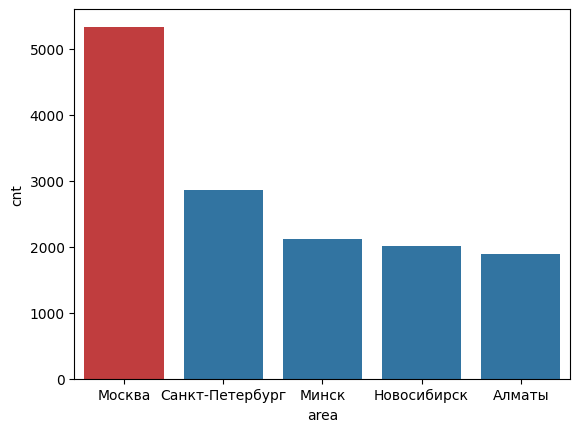

In [75]:
query_4_1 = f'''SELECT a.name area, COUNT(v.area_id) cnt
FROM vacancies v JOIN areas a ON v.area_id = a.id
GROUP BY a.id, a.name
ORDER BY 2 DESC
LIMIT 5
'''
df = pd.read_sql_query(query_4_1, engine)

filtred_color = [('tab:red' if x > 3000 else 'tab:blue') for x in df.cnt]
sns.barplot(df, x='area', y='cnt', palette=filtred_color);

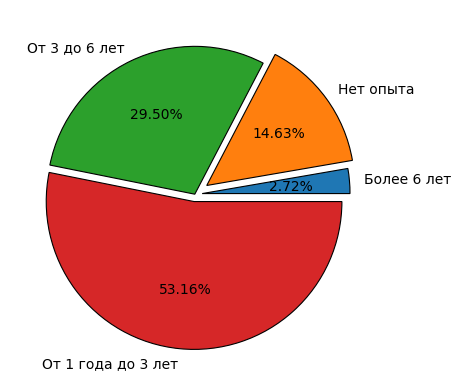

In [77]:
query_4_5 = f'''SELECT experience, COUNT(id)
FROM vacancies
GROUP BY 1
ORDER BY 2
'''
df = pd.read_sql_query(query_4_5, engine)

plt.pie(
    df['count'],
    labels = df['experience'].values,
    autopct = '%.2f%%',
    explode = (0.05, 0.1, 0, 0.05),
    wedgeprops = {'lw':0.8,'edgecolor':'k'},   
);

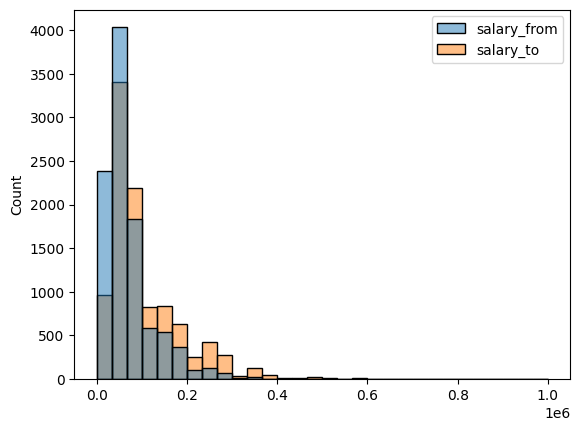

In [78]:
query_4_3 = f'''
SELECT 
    salary_from as salary_from, 
    salary_to as salary_to
FROM 
    vacancies
'''
df = pd.read_sql_query(query_4_3, engine)
df.dropna(inplace=True)
sns.histplot(data=df, bins=30);